![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Bartosz Bogucki |
<b>Student-nr</b>: r1032166 |
<b>Date</b>: March 30, 2025
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting.

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory:
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment are just sekeleton code,  **adapt where needed! And try to keep things structured!**

In [ ]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package:
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook
import pickle

import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef, fbeta_score

<div class="alert alert-block alert-info">
<b>Tip:</b>
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of synthetic similarity scores of four different biometric systems. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (impostor scores). The data can be found in the .csv files in the `./data/` subfolder.

In this code example we will compare the performance of four biometric systems. These systems are referred to as `system1`, `system2`, `system3` and `system4` respectively in both code and text.

<div class="alert alert-block alert-info">
<b>Tip:</b>
For each question, make sure to <b> compare the results for the different systems</b>!!! Mention which system performs the best/worst and why.</div>

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for all the systems:
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [ ]:
# STEP 1: loading the similarity matrices for the four systems
with open('./data/system1_similarity_matrix.csv','rb') as f:
    system1_similarity_matrix = pickle.load(f)
with open('./data/system2_similarity_matrix.csv','rb') as f:
    system2_similarity_matrix = pickle.load(f)
with open('./data/system3_similarity_matrix.csv','rb') as f:
    system3_similarity_matrix = pickle.load(f)
with open('./data/system4_similarity_matrix.csv','rb') as f:
    system4_similarity_matrix = pickle.load(f)
print(type(system1_similarity_matrix))
print(system1_similarity_matrix)

<class 'numpy.ndarray'>
[[ 6.48730361  0.69352768 -3.86501703 ...  2.12183612 -0.84331811
   2.29475023]
 [ 3.77365119  5.81647308  1.97903324 ... -0.54378096 -0.24531316
   0.69868077]
 [-1.80004577 -1.60213216  5.84154847 ... -0.58968609  0.7481939
  -0.9206928 ]
 ...
 [ 0.09193256 -0.16410043  0.93337656 ...  5.97911264  3.54499178
   1.48657273]
 [ 2.65662266 -1.28256359  2.09351615 ... -0.87710247  6.10616113
   0.65302102]
 [ 3.19788089  1.00973575  4.36628529 ...  3.37207976  1.62679603
   5.9439135 ]]


In [ ]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
def sim2scores(similarity_matrix):
    # use .values to access as numpy array
    np_similarity_matrix = similarity_matrix

    # grab elements on the diagonal
    genuine_scores = np.diag(np_similarity_matrix)

    # mask elements that are on the diagonal, retain non-diagonal elements
    imposter_scores =  np_similarity_matrix[~np.eye(np_similarity_matrix.shape[0],dtype=bool)]

    # store in one single list of scores as required for the classification validation procedures
    scores = np.append(np.array(genuine_scores), np.array(imposter_scores))

    # normalize to [0,1] range, 0 corresponding to minimal similarity
    scores = (scores - scores.min())/(scores.max()-scores.min())

    ## add the genuine and imposter labels

    # tag genuine combinations as label 1 and imposter combinations as 0

    genuine_id = np.zeros_like(scores)
    genuine_id[0:genuine_scores.shape[0]] = 1

    return(genuine_id, scores)


system1_genuine_id, system1_scores = sim2scores(system1_similarity_matrix)
system2_genuine_id, system2_scores = sim2scores(system2_similarity_matrix)
system3_genuine_id, system3_scores = sim2scores(system3_similarity_matrix)
system4_genuine_id, system4_scores = sim2scores(system4_similarity_matrix)

<div class="alert alert-block alert-info">
<b>Tip:</b>
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not?

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot for the four systems.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot. Which system performs the best based on this plot?</li>
  <li>Which system corresponds to which of the following descriptions?</li>
  <ol type = 'A'>
    <li> small inter-user distance, small intra-user variation </li>
    <li> small inter-user similarity, small intra-user variation </li>
    <li> large inter-user similarity, large intra-user variation </li>
    <li> large inter-user distance, large intra-user variation </li>
  </ol>
</ul>  
</div>

In [ ]:
# Dictionary to store system data
systems = {
    "System 1": (system1_genuine_id, system1_scores),
    "System 2": (system2_genuine_id, system2_scores),
    "System 3": (system3_genuine_id, system3_scores),
    "System 4": (system4_genuine_id, system4_scores)
}

colors = ['black', 'red', 'green', 'purple']  # Different colors for different systems

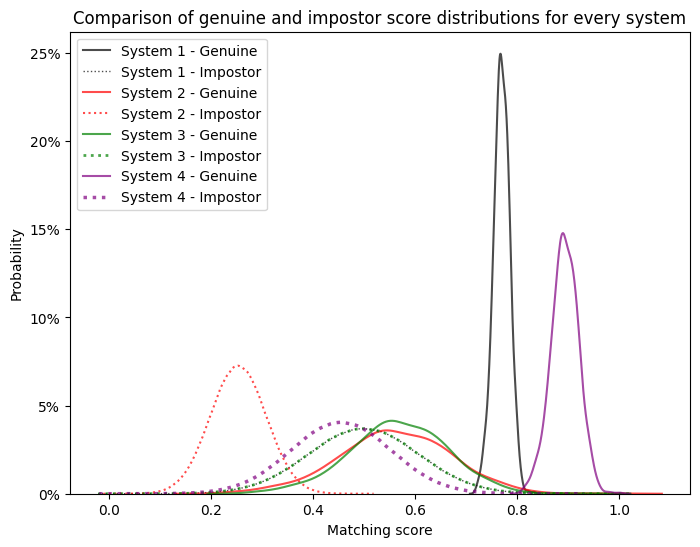

In [ ]:
"""Plots the genuine and impostor score distributions for multiple systems in one plot."""
plt.figure(figsize=(8, 6))

for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
    # Separate genuine and impostor scores
    genuine_scores = scores[genuine_id == 1]
    impostor_scores = scores[genuine_id == 0]

    # Plot KDE distributions (ensure different line styles for genuine and impostors)
    sns.kdeplot(genuine_scores, label=f"{system_name} - Genuine", color=colors[i], linestyle='-', alpha=0.7)
    sns.kdeplot(impostor_scores, label=f"{system_name} - Impostor", color=colors[i], linestyle=':', alpha=0.7, linewidth=1+i/2)

# Labels and title

# Function to format y-axis as percentage
def percent(x, pos):
    return f'{x:.0f}%'

# Set the y-axis formatter to display percentages
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

plt.xlabel("Matching score")
plt.ylabel("Probability")
plt.title("Comparison of genuine and impostor score distributions for every system")
plt.legend()
plt.show()

In [ ]:
print(f"The number of genuine cases {len(system1_scores[system1_genuine_id == 1])}.")
print(f"The number of impostor cases {len(system1_scores[system1_genuine_id == 0])}.")

The number of genuine cases 1000.
The number of impostor cases 999000.


#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR).

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of the decision threshold.</li>
    <li>Plot the ROC curve for the four systems <b> in a single plot </b>. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b>
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

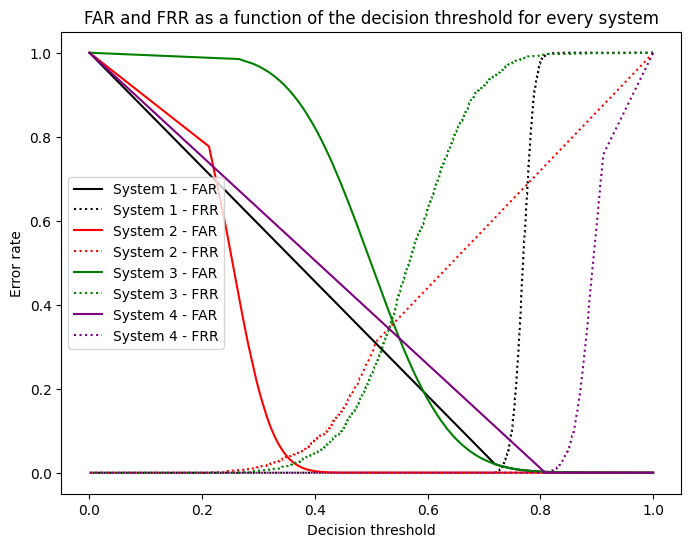

In [ ]:
def plot_far_frr(systems):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        """Calculate FPR, TPR from the matching scores."""
        fpr, tpr, thresholds = roc_curve(genuine_id, scores)

        """Plot FAR and FRR as a function of the decision threshold."""
        # FAR <=> FPR
        far = fpr
        # FRR <=> FNR <=> FN/P <=> 1-TPR
        frr = 1 - tpr

        plt.plot(thresholds, far, label=f"{system_name} - FAR", linestyle="-", color=colors[i])
        plt.plot(thresholds, frr, label=f"{system_name} - FRR", linestyle=":", color=colors[i])

    plt.xlabel("Decision threshold")
    plt.ylabel("Error rate")
    plt.title("FAR and FRR as a function of the decision threshold for every system")
    plt.legend()
    plt.show()

plot_far_frr(systems)

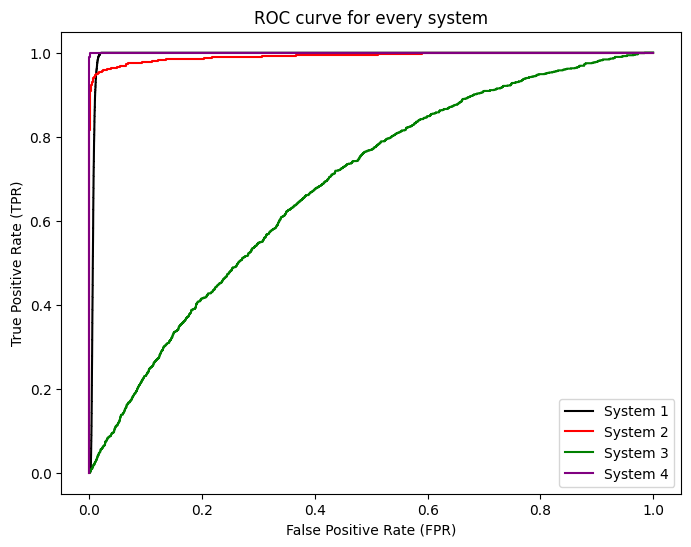

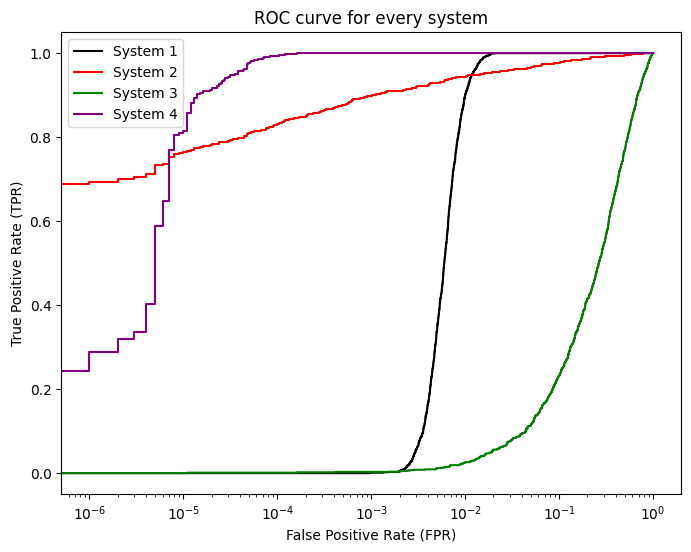

In [ ]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
def plot_roc_curve(systems, log_scale=False):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        """Calculate FPR, TPR from the matching scores."""
        fpr, tpr, _ = roc_curve(genuine_id, scores)
        plt.plot(fpr, tpr, label=f"{system_name}", color=colors[i])

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC curve for every system")
    plt.legend()
    if log_scale == True:
        plt.xscale("log")
    plt.show()
    plt.show()

plot_roc_curve(systems)
plot_roc_curve(systems, log_scale=True)

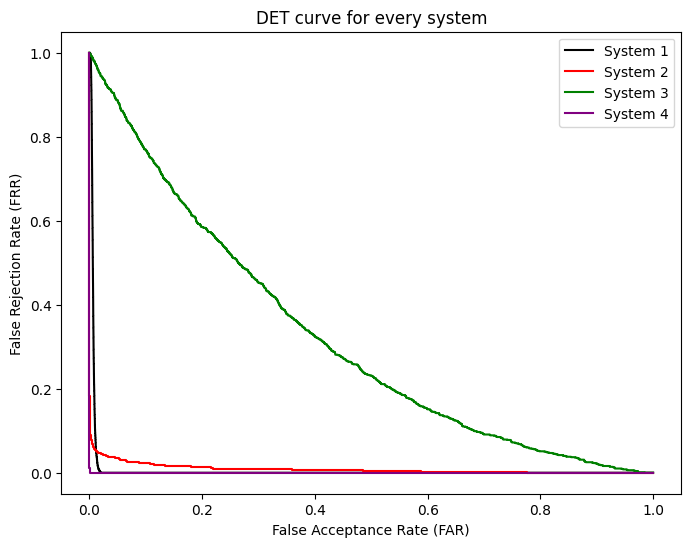

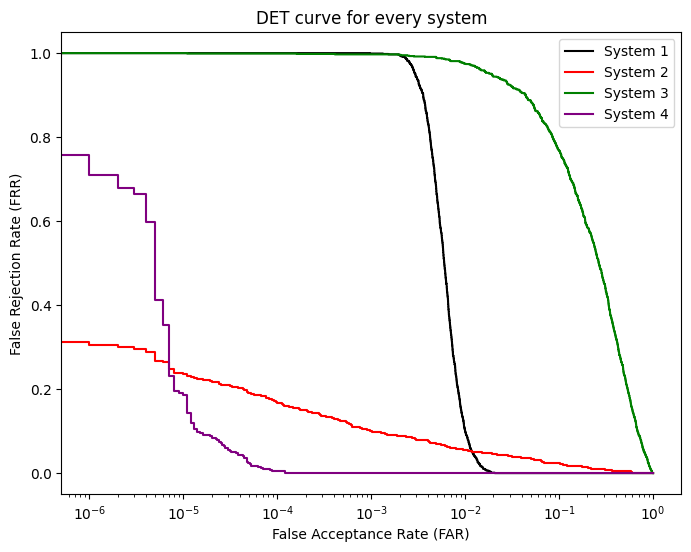

In [ ]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
def plot_det_curve(systems, log_scale=False):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        """Calculate FPR, TPR from the matching scores."""
        fpr, tpr, _ = roc_curve(genuine_id, scores)
        # FAR <=> FPR
        far = fpr
        # FRR <=> FNR <=> FN/P <=> 1-TPR
        frr = 1 - tpr
        plt.plot(far, frr, label=system_name, color=colors[i])

    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("False Rejection Rate (FRR)")
    plt.title("DET curve for every system")
    plt.legend()
    if log_scale == True:
        plt.xscale("log")
    plt.show()

plot_det_curve(systems)
plot_det_curve(systems, log_scale=True)

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure.

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score for the four systems<b> in a single plot </b>.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Calculate the threshold and F1 for which accuracy is maximal. Is it an interesting operating point? Is there a difference with the results of the previous question and why?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b>
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


System 1:
  Max F1-score: 0.1567 at threshold 0.7551 with accuracy of 0.9912
  Max Accuracy: 0.9990 at threshold 1.0000 with F1-score of 0.0000

System 2:
  Max F1-score: 0.8684 at threshold 0.4694 with accuracy of 0.9998
  Max Accuracy: 0.9998 at threshold 0.4694 with F1-score of 0.8684

System 3:
  Max F1-score: 0.0051 at threshold 0.7347 with accuracy of 0.9847
  Max Accuracy: 0.9990 at threshold 1.0000 with F1-score of 0.0000

System 4:
  Max F1-score: 0.9634 at threshold 0.8367 with accuracy of 0.9999
  Max Accuracy: 0.9999 at threshold 0.8367 with F1-score of 0.9634



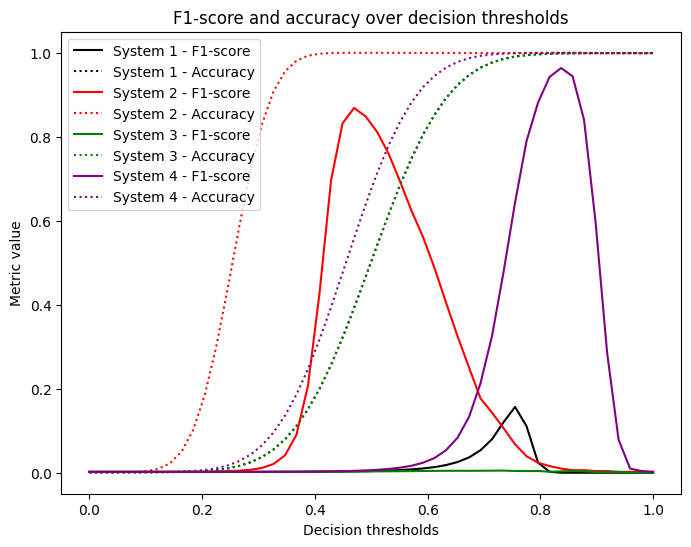

In [ ]:
def evaluate_metrics(genuine_id, scores, thresholds):
    """Compute F1-score and accuracy for different threshold values."""
    f1_scores = []
    accuracies = []

    for threshold in thresholds:
        predictions = (scores >= threshold).astype(int)
        f1_scores.append(f1_score(genuine_id, predictions))
        accuracies.append(accuracy_score(genuine_id, predictions))

    return np.array(f1_scores), np.array(accuracies)

def plot_f1_accuracy(systems, thresholds):
    """Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        f1_scores, accuracies = evaluate_metrics(genuine_id, scores, thresholds)

        plt.plot(thresholds, f1_scores, linestyle='-', label=f"{system_name} - F1-score", color=colors[i])
        plt.plot(thresholds, accuracies, linestyle=':', label=f"{system_name} - Accuracy", color=colors[i])

        """Calculate the threshold and accuracy for which F1 is maximal."""
        max_f1_index = np.argmax(f1_scores)
        max_f1_value = f1_scores[max_f1_index]
        max_f1_threshold = thresholds[max_f1_index]
        max_f1_accuracy = accuracies[max_f1_index]

        """Calculate the threshold and F1 for which accuracy is maximal."""
        max_acc_index = np.argmax(accuracies)
        max_acc_value = accuracies[max_acc_index]
        max_acc_threshold = thresholds[max_acc_index]
        max_acc_f1 = f1_scores[max_acc_index]

        print(f"{system_name}:")
        print(f"  Max F1-score: {max_f1_value:.4f} at threshold {max_f1_threshold:.4f} with accuracy of {max_f1_accuracy:.4f}")
        print(f"  Max Accuracy: {max_acc_value:.4f} at threshold {max_acc_threshold:.4f} with F1-score of {max_acc_f1:.4f}\n")

    plt.xlabel("Decision thresholds")
    plt.ylabel("Metric value")
    plt.title("F1-score and accuracy over decision thresholds")
    plt.legend()
    plt.show()

thresholds = np.linspace(0, 1, 50)  # 50 threshold values between 0 and 1
plot_f1_accuracy(systems, thresholds)

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance.

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li>
    <li>Discuss the importance of the FRR and the FAR if you want a very secure versus a very convenient system. </li>
</ul>  
</div>


In [ ]:
"""Calculate the ROC AUC."""
for system_name, (genuine_id, scores) in systems.items():
    auc_score = roc_auc_score(genuine_id, scores)
    print(f"ROC AUC for {system_name} is {auc_score*100:.4f}%")

ROC AUC for System 1 is 99.3515%
ROC AUC for System 2 is 99.1636%
ROC AUC for System 3 is 68.3340%
ROC AUC for System 4 is 99.9992%


System 1:
  EER decision threshold: 0.7327
  EER value: 0.0151

  The decision threshold for which the sum of FRR and FAR is minimal: 0.7235
  Minimal sum of FRR and FAR: 0.0196 (FRR of 0.0010 and FAR of 0.0186)

  The decision threshold for which total classification error is minimal: inf
  Minimal total classification error: 0.0010

System 2:
  EER decision threshold: 0.3503
  EER value: 0.0391

  The decision threshold for which the sum of FRR and FAR is minimal: 0.3778
  Minimal sum of FRR and FAR: 0.0627 (FRR of 0.0510 and FAR of 0.0117)

  The decision threshold for which total classification error is minimal: 0.4772
  Minimal total classification error: 0.0002

System 3:
  EER decision threshold: 0.5365
  EER value: 0.3652

  The decision threshold for which the sum of FRR and FAR is minimal: 0.5166
  Minimal sum of FRR and FAR: 0.7172 (FRR of 0.2810 and FAR of 0.4362)

  The decision threshold for which total classification error is minimal: inf
  Minimal total classification e

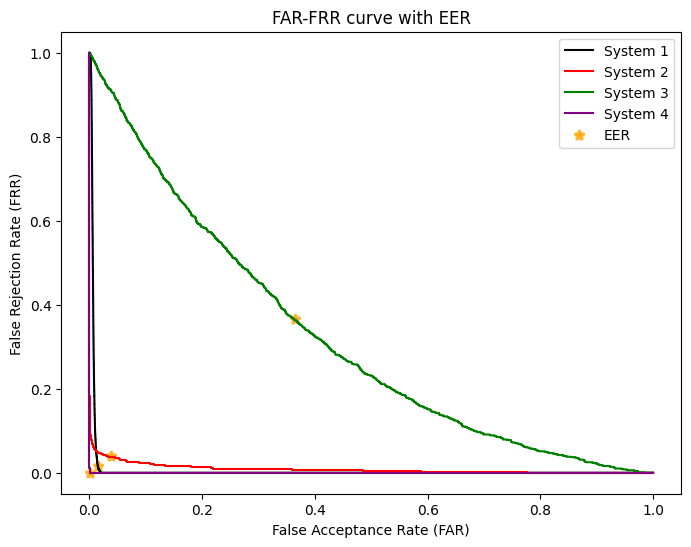

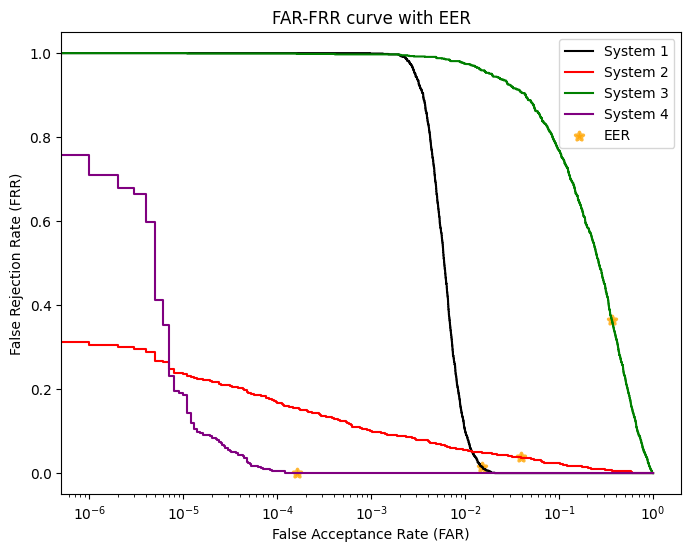

In [ ]:
def find_eer(genuine_id, scores):
    """Calculate (by approximation) the EER."""
    # Calculate FAR and FRR over different thresholds
    fpr, tpr, thresholds = roc_curve(genuine_id, scores)

    far = fpr
    frr = 1 - tpr

    # Calculate the absolute difference between FAR and FRR for each threshold
    difference = np.abs(far - frr)

    # The index where the difference is minimum is (by approximation) the EER point
    eer_index = np.argmin(difference)
    eer_decision_threshold = thresholds[eer_index]
    eer_value = fpr[eer_index]  # Since FAR == FRR at EER

    # Calculate the decision threshold for which the sum of FRR and FAR is minimal
    sum_frr_far = far + frr
    sum_frr_far_min_index = np.argmin(sum_frr_far)
    min_sum_frr_far_decision_threshold = thresholds[sum_frr_far_min_index]
    min_sum_frr_far_value = sum_frr_far[sum_frr_far_min_index]
    min_sum_frr_far_value_of_far = far[sum_frr_far_min_index]
    min_sum_frr_far_value_of_frr = frr[sum_frr_far_min_index]

    # Compute Total Classification Error (absolute misclassifications)
    total_samples = len(genuine_id)
    num_genuine = np.sum(genuine_id == 1)
    num_impostors = np.sum(genuine_id == 0)
    FP = fpr * num_impostors
    FN = (1 - tpr) * num_genuine

    total_error = FP + FN
    min_tce_index = np.argmin(total_error)  # Find threshold minimizing TCE
    min_tce_threshold = thresholds[min_tce_index]
    min_tce_value = total_error[min_tce_index] / total_samples  # Normalize TCE by total samples

    return far, frr, thresholds, eer_decision_threshold, eer_value, min_sum_frr_far_decision_threshold, min_sum_frr_far_value, min_sum_frr_far_value_of_far, min_sum_frr_far_value_of_frr, min_tce_threshold, min_tce_value

def plot_far_frr_with_eer(systems, log_scale=False):
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        far, frr, thresholds, eer_decision_threshold, eer_value, min_sum_frr_far_decision_threshold, min_sum_frr_far_value, min_sum_frr_far_value_of_far, min_sum_frr_far_value_of_frr, min_tce_threshold, min_tce_value = find_eer(genuine_id, scores)

        plt.plot(far, frr, label=f"{system_name}", color=colors[i])
        eer_marker = plt.scatter(eer_value, eer_value, color='orange', marker='*', alpha=0.8, linewidth=2.5)
        if log_scale == False:
            print(f"{system_name}:")
            print(f"  EER decision threshold: {eer_decision_threshold:.4f}")
            print(f"  EER value: {eer_value:.4f}\n")
            print(f"  The decision threshold for which the sum of FRR and FAR is minimal: {min_sum_frr_far_decision_threshold:.4f}")
            print(f"  Minimal sum of FRR and FAR: {min_sum_frr_far_value:.4f} (FRR of {min_sum_frr_far_value_of_frr:.4f} and FAR of {min_sum_frr_far_value_of_far:.4f})\n")
            print(f"  The decision threshold for which total classification error is minimal: {min_tce_threshold:.4f}")
            print(f"  Minimal total classification error: {min_tce_value:.4f}\n")

    # Add all system curves to legend first, then add EER as the last entry
    handles, labels = plt.gca().get_legend_handles_labels()
    if eer_marker is not None:
        handles.append(eer_marker)
        labels.append("EER")
    plt.legend(handles, labels)

    plt.xlabel("False Acceptance Rate (FAR)")
    plt.ylabel("False Rejection Rate (FRR)")
    plt.title("FAR-FRR curve with EER")
    if log_scale == True:
        plt.xscale("log")
    plt.show()

# Example usage (assuming `systems` is a dictionary of systems with their true labels and scores)
plot_far_frr_with_eer(systems)
plot_far_frr_with_eer(systems, log_scale=True)

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">

<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for these systems. What does it reveal about the performance of the systems?</li>
    <li>Does the ROC curve or the PRC curve make more sense to evaluate these four systems? (Tip: read the webpages mentioned above). </li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li>
</ul>  
</div>


PR-curve AUC for System 1 is 0.0653
Average Precision for System 1 is 0.0654
PR-curve AUC for System 2 is 0.8877
Average Precision for System 2 is 0.8877
PR-curve AUC for System 3 is 0.0019
Average Precision for System 3 is 0.0020
PR-curve AUC for System 4 is 0.9893
Average Precision for System 4 is 0.9893


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


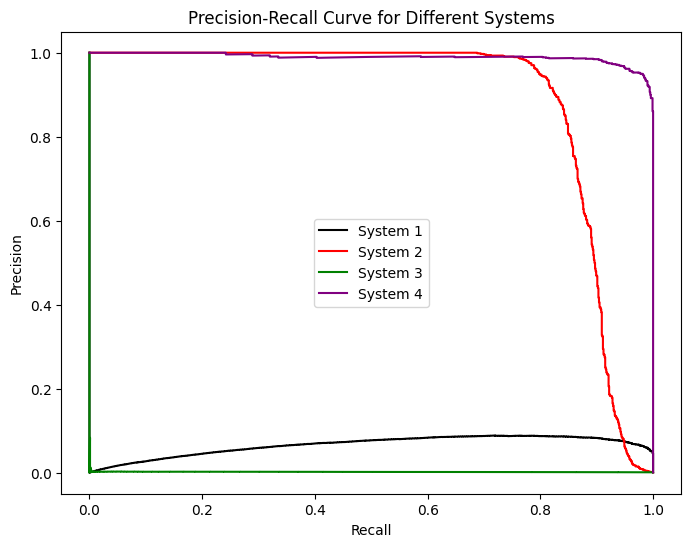

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


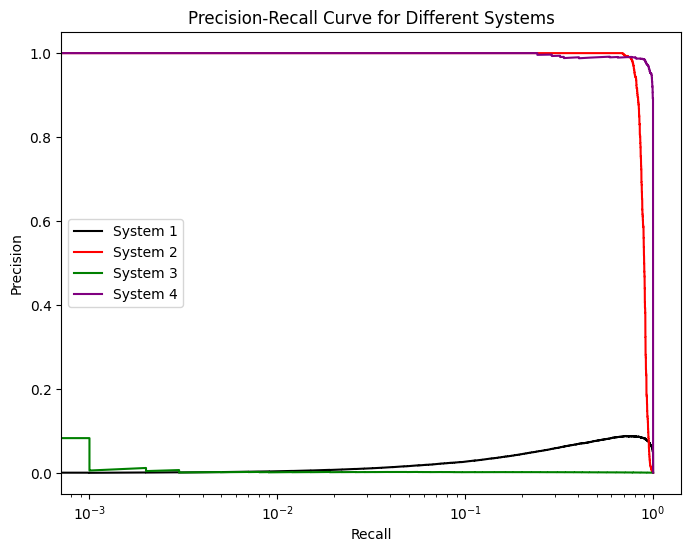

In [ ]:
def precision_recall_analysis(systems, log_scale=False):
    """Calculate and plot the Precision-Recall curve for the systems"""
    """Calculate the Area Under the PR-curve."""
    """Calculate the average precision scores"""
    plt.figure(figsize=(8, 6))

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        precision, recall, thresholds = precision_recall_curve(genuine_id, scores)

        # Plot the Precision-Recall curve
        plt.plot(recall, precision, label=f'{system_name}', color=colors[i])

        if log_scale == False:
            auc_score = auc(recall, precision)  # AUC for Precision-Recall curve
            print(f"PR-curve AUC for {system_name} is {auc_score:.4f}")

            ap_score = average_precision_score(genuine_id, scores)  # Compute AP
            print(f"Average Precision for {system_name} is {ap_score:.4f}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Different Systems')
    plt.legend()
    if log_scale == True:
        plt.xscale("log")
    plt.show()

precision_recall_analysis(systems)
precision_recall_analysis(systems, log_scale=True)

## III. Validation of identification system

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores.

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample).



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


Rank-1 Recognition Rate for System 1: 0.0100
Rank-1 Recognition Rate for System 2: 0.8770
Rank-1 Recognition Rate for System 3: 0.0040
Rank-1 Recognition Rate for System 4: 0.9910


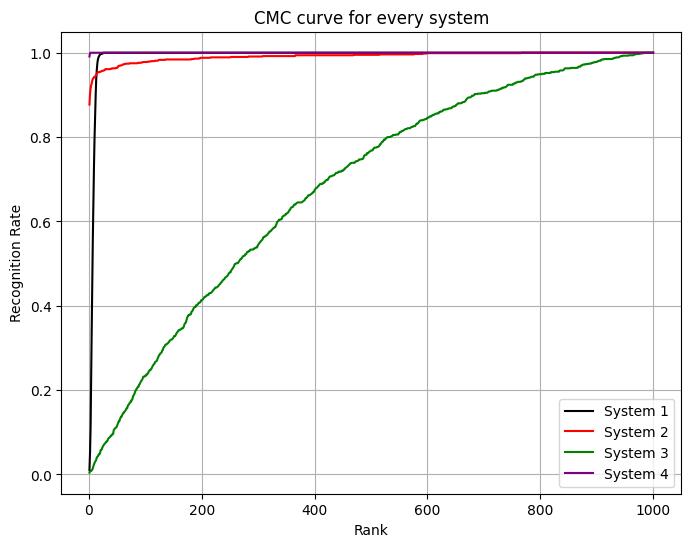

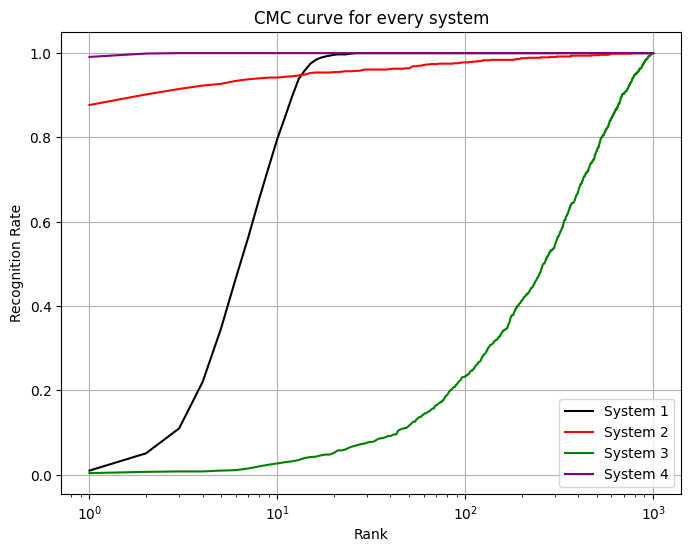

In [ ]:
similarity_matrices = {
    "System 1": (system1_similarity_matrix),
    "System 2": (system2_similarity_matrix),
    "System 3": (system3_similarity_matrix),
    "System 4": (system4_similarity_matrix)
}

def cmc_analysis(similarity_matrices, log_scale=False, whether_print=1):
    """Calculate and plot the CMC curve and Rank-1 Recognition Rate for all systems."""
    plt.figure(figsize=(8, 6))

    for j, (system_name, similarity_matrix) in enumerate(similarity_matrices.items()):
        num_probes = similarity_matrix.shape[0]
        ranks = []

        for i in range(num_probes):
            # Get similarity scores for the i-th probe
            probe_scores = similarity_matrix[i, :]

            # Sort gallery samples by similarity score in descending order
            sorted_indices = np.argsort(probe_scores)[::-1]  # Get indices of sorted scores (descending)

            # The correct match is always at diagonal
            rank = np.where(sorted_indices == i)[0][0] + 1  # Convert to 1-based rank
            ranks.append(rank)

        # Compute CMC curve
        cmc_curve = np.zeros(num_probes)
        for k in range(1, num_probes + 1):
            cmc_curve[k - 1] = sum(np.array(ranks) <= k)/len(ranks) # Get number of Trues divided by number of probes

        rank_1_recognition_rate = cmc_curve[0]  # CMC(1) gives the Rank-1 recognition rate
        if whether_print>0:
            print(f"Rank-1 Recognition Rate for {system_name}: {rank_1_recognition_rate:.4f}")
        plt.plot(range(1, len(cmc_curve) + 1), cmc_curve, label=f"{system_name}", color=colors[j])
    plt.xlabel("Rank")
    plt.ylabel("Recognition Rate")
    plt.title("CMC curve for every system")
    plt.legend()
    plt.grid()
    if log_scale:
        plt.xscale("log")
    plt.show()

cmc_analysis(similarity_matrices)
cmc_analysis(similarity_matrices, log_scale=True, whether_print=0)

<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Propose a new metric not mentioned in this task to evaluate these four systems. This can be something you come up with yourself by adjusting/combining some of the existing metrics in this task or something you find online. Explain in what way your new method is more/less suited to evaluate these systems </li>
</ul>  
</div>

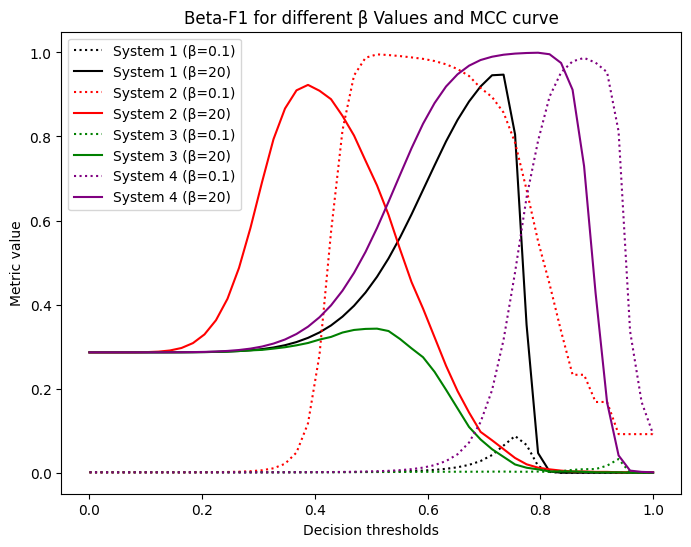

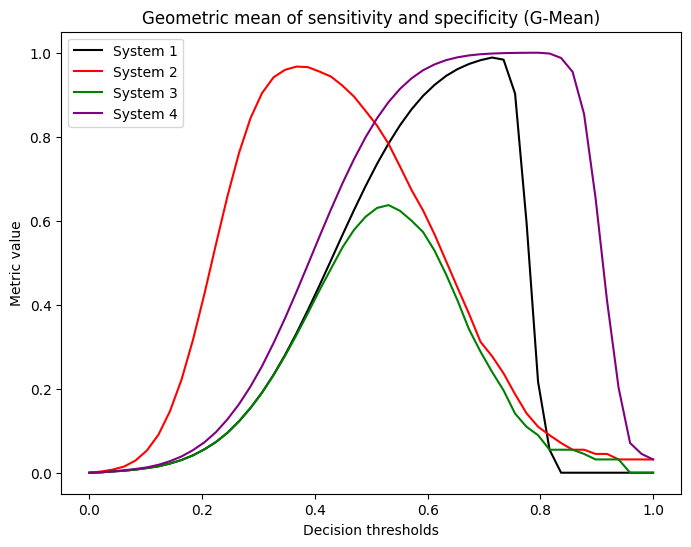

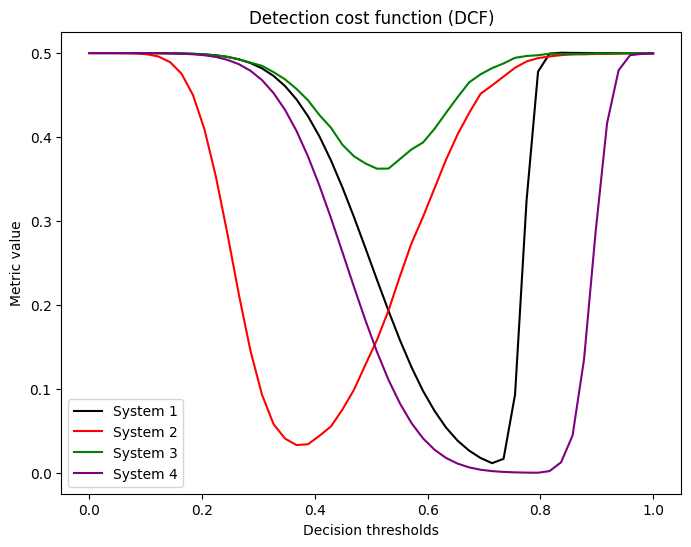

System 1:
  Max Beta-F1 (Beta=0.1): 0.0874 at threshold 0.7551
  Max Beta-F1 (Beta=20): 0.9472 at threshold 0.7347
  Max G-Mean: 0.9884 at threshold 0.7143
  Min DCF: 0.0115 at threshold 0.7143

System 2:
  Max Beta-F1 (Beta=0.1): 0.9954 at threshold 0.5102
  Max Beta-F1 (Beta=20): 0.9228 at threshold 0.3878
  Max G-Mean: 0.9669 at threshold 0.3673
  Min DCF: 0.0330 at threshold 0.3673

System 3:
  Max Beta-F1 (Beta=0.1): 0.0326 at threshold 0.9388
  Max Beta-F1 (Beta=20): 0.3428 at threshold 0.5102
  Max G-Mean: 0.6371 at threshold 0.5306
  Min DCF: 0.3623 at threshold 0.5102

System 4:
  Max Beta-F1 (Beta=0.1): 0.9870 at threshold 0.8776
  Max Beta-F1 (Beta=20): 0.9993 at threshold 0.7959
  Max G-Mean: 0.9999 at threshold 0.7959
  Min DCF: 0.0001 at threshold 0.7959



In [17]:
def geometric_mean(genuine_id, predictions):
    """Calculate the Geometric Mean (GM)."""
    tn, fp, fn, tp = confusion_matrix(genuine_id, predictions).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return np.sqrt(sensitivity * specificity)

def detection_cost_function(genuine_id, predictions, c_miss=1, c_fa=1, prior_genuine=0.5):
    """Calculate the Detection Cost Function (DCF)."""
    tn, fp, fn, tp = confusion_matrix(genuine_id, predictions).ravel()
    frr = fn / (fn + tp) if (fn + tp) > 0 else 0
    far = fp / (fp + tn) if (fp + tn) > 0 else 0
    dcf = c_miss * frr * prior_genuine + c_fa * far * (1 - prior_genuine)
    return dcf

def evaluate_metrics(genuine_id, scores, thresholds, beta_values):
    """Compute all metrics for different threshold values."""
    beta_f1_scores = {beta: [] for beta in beta_values}
    mcc_scores = []
    gmean_scores = []
    dcf_scores = []

    for threshold in thresholds:
        predictions = (scores >= threshold).astype(int)

        for beta in beta_values:
            beta_f1_scores[beta].append(fbeta_score(genuine_id, predictions, beta=beta))

        mcc_scores.append(matthews_corrcoef(genuine_id, predictions))
        gmean_scores.append(geometric_mean(genuine_id, predictions))
        dcf_scores.append(detection_cost_function(genuine_id, predictions))

    return beta_f1_scores, np.array(mcc_scores), np.array(gmean_scores), np.array(dcf_scores)

def plot_metrics(systems, thresholds, beta_values):
    """Plot evaluation metrics as a function of the decision thresholds."""

    # Store computed metrics for each system
    computed_metrics = {}

    for i, (system_name, (genuine_id, scores)) in enumerate(systems.items()):
        computed_metrics[system_name] = evaluate_metrics(genuine_id, scores, thresholds, beta_values)

    # Plot F1-score over different betas
    plt.figure(figsize=(8, 6))
    for i, (system_name, (beta_f1_scores, mcc_scores, _, _)) in enumerate(computed_metrics.items()):
        for j, beta in enumerate(beta_values):
            plt.plot(thresholds, beta_f1_scores[beta], linestyle=linestyles[j], color=colors[i],
                     label=f"{system_name} (β={beta})")
        # Plot MCC scores with different linestyles
        # plt.plot(thresholds, mcc_scores, linestyle="-", color=colors[i], label=f"{system_name} - MCC")
    plt.xlabel("Decision thresholds")
    plt.ylabel("Metric value")
    plt.title("Beta-F1 for different β Values and MCC curve")
    plt.legend()
    plt.show()

    # Plot G-mean and DCF
    metric_names = ["Geometric mean of sensitivity and specificity (G-Mean)", "Detection cost function (DCF)"]
    for metric_name in metric_names:
        plt.figure(figsize=(8, 6))
        for i, (system_name, (_, _, gmean_scores, dcf_scores)) in enumerate(computed_metrics.items()):
            if metric_name.startswith("Geometric"):
                plt.plot(thresholds, gmean_scores, color=colors[i], label=f"{system_name}")
            elif metric_name.startswith("Detection"):
                plt.plot(thresholds, dcf_scores, color=colors[i], label=f"{system_name}")

        plt.xlabel("Decision thresholds")
        plt.ylabel("Metric value")
        plt.title(metric_name)
        plt.legend()
        plt.show()

    # Print optimal thresholds
    for system_name, (beta_f1_scores, mcc_scores, gmean_scores, dcf_scores) in computed_metrics.items():
        # Find best thresholds
        best_f1_thresholds = {beta: thresholds[np.argmax(beta_f1_scores[beta])] for beta in beta_values}
        best_mcc_threshold = thresholds[np.argmax(mcc_scores)]
        best_gmean_threshold = thresholds[np.argmax(gmean_scores)]
        best_dcf_threshold = thresholds[np.argmin(dcf_scores)]

        # Print results
        print(f"{system_name}:")
        for beta in beta_values:
            max_f1 = max(beta_f1_scores[beta])
            print(f"  Max Beta-F1 (Beta={beta}): {max_f1:.4f} at threshold {best_f1_thresholds[beta]:.4f}")
        # print(f"  Max MCC: {max(mcc_scores):.4f} at threshold {best_mcc_threshold:.4f}")
        print(f"  Max G-Mean: {max(gmean_scores):.4f} at threshold {best_gmean_threshold:.4f}")
        print(f"  Min DCF: {min(dcf_scores):.4f} at threshold {best_dcf_threshold:.4f}\n")

# Define thresholds and beta values
thresholds = np.linspace(0, 1, 50)  # 50 evenly spaced thresholds
beta_values = [0.1, 20]  # Different Beta values for Weighted Beta-F1 Score # β=2 → recall-focused (convenience focused) # β=0.5 → precision-focused (security focused)
linestyles = [":", "-"]  # Different linestyles per beta value

plot_metrics(systems, thresholds, beta_values)

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 5-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Make sure to compare the performance of the four biometric systems in each question. **The report should be self contained, the notebook functions as supplementary material only! Make sure to add all relevant figures and results in the text!**

Your submission should be a .zip file with the name formatted as Assignment1_[Your student number].zip. You should replace [Your student number] with your r-number, with the r.

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
